# Kitaev Model: Toric Code

Kitaev Hamiltonian:
$
\begin{equation}
H_K = - \sum_p B_p - \sum_s A_s
\end{equation}
$

With operators defined as:

$
\begin{align}
B_p &= \Pi_{(ij) \in p} \sigma_{(ij)}^z \\
A_s &= \Pi_{(ij) \in s} \sigma_{(ij)}^x \\
\end{align}
$

where $p$ is a <span style="color:blue"> plaquette </span> (in blue below) of the lattice and $s$ is a <span style="color:red">star vertex</span> (in red below) of the lattice.

The Toric Code is a lattice embedded onto a torus with spin-1/2 particles on the <strong>bonds</strong>. If we "flatten" the torus out onto a plane, we get something like the image below where the lattice is marked in black (ignoring the blue and red)
![](./images/four_by_four.png)
There are 8 spins on this lattice marked by x's. In the interactions in Kitaev's Model take place among spins in each blue and red group. For example, in the image below, each spin is labeled and each interaction group labeled: there are four blue groups and four red groups. The spins belonging to each group interact with each other (more details later). Since the lattice is on a torus there are periodic boundaries. This means the right most spins in the image are actually neighbors with the left most spins, and the top most spins are neighbors with the bottom most spins.
![](./images/four_by_four_labeled.png)

In [1]:
import numpy as np

from qiskit import QuantumCircuit, Aer, execute
from qiskit.visualization import plot_state_hinton
from qiskit.compiler import transpile

Consider the specific scenario depicted above. The total number of spins $N_{spins} = 8$. The number of plaquettes $N_p = 4$, and the number of star verticies $N_s = 4$.

In [2]:
Nspins = 8  # number of spins on lattice
Np = 4  # number of plaquettes
Ns = 4  # number of star vertices

Generate $B_p$ and $A_s$ operators. Since there are only $8$ spins in total, I'll just write them in by hand. Later, we can automate it based off a graph representing the spin sites.

In [3]:
x = np.array([[0,1],[1,0]])
z = np.array([[1,0],[0,-1]])
iden = np.identity(2)

Bp_s = []  # list of Bp operators indexed from 0 to 3
Bp_s.append(np.kron(np.kron(np.kron(np.kron(np.kron(np.kron(np.kron(z, iden), z), z), z), iden), iden), iden))
Bp_s.append(np.kron(np.kron(np.kron(np.kron(np.kron(np.kron(np.kron(iden, z), z), z), iden), z), iden), iden))
Bp_s.append(np.kron(np.kron(np.kron(np.kron(np.kron(np.kron(np.kron(z, iden), iden), iden), z), iden), z), z))
Bp_s.append(np.kron(np.kron(np.kron(np.kron(np.kron(np.kron(np.kron(iden, z), iden), iden), iden), z), z), z))

As_s = []  # list of As operators indexed from 0 to 3
As_s.append(np.kron(np.kron(np.kron(np.kron(np.kron(np.kron(np.kron(iden, iden), x), iden), x), x), x), iden))
As_s.append(np.kron(np.kron(np.kron(np.kron(np.kron(np.kron(np.kron(iden, iden), iden), x), x), x), iden), x))
As_s.append(np.kron(np.kron(np.kron(np.kron(np.kron(np.kron(np.kron(x, x), x), iden), iden), iden), x), iden))
As_s.append(np.kron(np.kron(np.kron(np.kron(np.kron(np.kron(np.kron(x, x), iden), x), iden), iden), iden), x))

Check $B_p$ and $A_s$ operators commute according to

$
\begin{align}
[B_p, B_{p\prime}] &= 0 \\
[A_s, A_{s\prime}] &= 0 \\
[B_p, A_s] &= 0 \\
\end{align}
$

Check that periodic boundary condition

$
\begin{align}
\Pi_s A_s &= 1 \\
\Pi_p B_p &= 1 \\
\end{align}
$

holds.


In [4]:
# Check commutation relations. Print if there something does NOT commute

# Commutation between different Bp operators
for i in range(len(Bp_s) - 1):
    if not np.array_equal(np.matmul(Bp_s[i], Bp_s[i+1]), np.matmul(Bp_s[i+1], Bp_s[i])):
        print('Bp', i, 'does not commute with Bp', i+1)

# Commutation between different As operators
for i in range(len(As_s) - 1):
    if not np.array_equal(np.matmul(As_s[i], As_s[i+1]), np.matmul(As_s[i+1], As_s[i])):
        print('As', i, 'does not commute with As', i+1)

# Commutation between different Bp and As operators
for i in range(len(As_s)):
    for j in range(len(Bp_s)):
        if not np.array_equal(np.matmul(As_s[i], Bp_s[j]), np.matmul(Bp_s[j], As_s[i])):
            print('As', i, 'does not commute with As', i+1)

# Check periodic boundary condition
Bp_product = np.identity(Bp_s[0].shape[0])
for i in range(len(Bp_s)):
    Bp_product = np.matmul(Bp_product, Bp_s[i])
print('Is the product of Bp operators equal to the identity matrix?:', np.array_equal(Bp_product, np.identity(Bp_s[0].shape[0])))

As_product = np.identity(As_s[0].shape[0])
for i in range(len(As_s)):
    As_product = np.matmul(As_product, As_s[i])
print('Is the product of As operators equal to the identity matrix?:', np.array_equal(As_product, np.identity(As_s[0].shape[0])))

Is the product of Bp operators equal to the identity matrix?: True
Is the product of As operators equal to the identity matrix?: True


Looks like everything checks out. Now to compute the Hamiltonian $H_K$

In [5]:
# Sum all the Bp and As operators
H_k = -sum(Bp_s) - sum(As_s)

# Compute eigenvalues and eigenvectors of Hamiltonian

In [6]:
# Compute eigenvalues and eigenvectors
# Should be four ground states because lattice is on a torus
# 1st excited state energy must be 4 above ground state again due to torus manifold
eigen_vals, eigen_vecs = np.linalg.eig(H_k)

# Clean up eigenvalues
eigen_vals = np.round(np.real(eigen_vals), 4)
unqiue_eigvals, counts = np.unique(eigen_vals, return_counts=True)
print(unqiue_eigvals, counts)

# normalize eigenvectors
eigen_vecs = np.round(np.real(eigen_vecs), 4)
norms = np.linalg.norm(eigen_vecs, ord=2, axis=1)
for i, norm in enumerate(norms):
    eigen_vecs[i] = eigen_vecs[i] / norm
print('average norm:', np.mean(np.linalg.norm(eigen_vecs, ord=2, axis=1)))

[-8. -4. -0.  4.  8.] [  4  48 152  48   4]
average norm: 1.0


In [7]:
# 4 ground states and check orthogonality
ground_states = []
ground_energy = eigen_vals.min()
for i, val in enumerate(eigen_vals):
    if val == ground_energy:
        ground_states.append(eigen_vecs[i])

# Inner product should be 1 between ground state 0 and itself and 0 between ground state 0 and the other 3 ground states  
for j in range(len(ground_states)):
    print('inner prodict of 0 and ',j,'state')
    inner_product = np.matmul(np.conj(ground_states[0]), ground_states[j][np.newaxis].T)[0]
    print(inner_product)


inner prodict of 0 and  0 state
0.9999999999999999
inner prodict of 0 and  1 state
-0.03990973939708617
inner prodict of 0 and  2 state
-0.003005483570822708
inner prodict of 0 and  3 state
-0.13505679902182943


In [8]:
eigen_vals.min()

-8.0

# See what happens when single qubit error acts on a site

In [9]:
error = np.kron(np.kron(np.kron(np.kron(np.kron(np.kron(np.kron(iden, z), iden), iden), iden), iden), iden), iden)


i = 0
np.matmul(np.conj(ground_states[i]), np.matmul(H_k, ground_states[i]))

-0.5744760165761754

In [10]:
ground_states[1].shape

(256,)

# Smaller Geometry for Trapped Ions
What if we use a lattice geometry achievable in one of our ion traps? Four spins sites might do the trick. We can definitely make this geometry in the trap. Let's see how the theory plays out.
![](./images/two_by_two_labeled.png)

In [11]:
Nspins = 4  # number of spins on lattice
Np = 2  # number of plaquettes
Ns = 2  # number of star vertices

Generate $B_p$ and $A_s$ operators. Since there are only $8$ spins in total, I'll just write them in by hand. Later, we can automate it based off a graph representing the spin sites.

In [12]:
x = np.array([[0,1],[1,0]])
z = np.array([[1,0],[0,-1]])
iden = np.identity(2)

# Both plaquettes are identical!
Bp_s = []  # list of Bp operators indexed from 0 to 1
Bp_s.append(np.kron(np.kron(np.kron(z, z), z), z))
Bp_s.append(np.kron(np.kron(np.kron(z, z), z), z))

# Both As operators are the identity!
As_s = []  # list of As operators indexed from 0 to 1
As_s.append(np.matmul(np.kron(np.kron(np.kron(x, x), iden), iden), np.kron(np.kron(np.kron(x, x), iden), iden)))
As_s.append(np.matmul(np.kron(np.kron(np.kron(iden, iden), x), x), np.kron(np.kron(np.kron(iden, iden), x), x)))

Check $B_p$ and $A_s$ operators commute according to

$
\begin{align}
[B_p, B_{p\prime}] &= 0 \\
[A_s, A_{s\prime}] &= 0 \\
[B_p, A_s] &= 0 \\
\end{align}
$

Check that periodic boundary condition

$
\begin{align}
\Pi_s A_s &= 1 \\
\Pi_p B_p &= 1 \\
\end{align}
$

holds.


In [13]:
# Check commutation relations. Print if there something does NOT commute

# Commutation between different Bp operators
for i in range(len(Bp_s) - 1):
    if not np.array_equal(np.matmul(Bp_s[i], Bp_s[i+1]), np.matmul(Bp_s[i+1], Bp_s[i])):
        print('Bp', i, 'does not commute with Bp', i+1)

# Commutation between different As operators
for i in range(len(As_s) - 1):
    if not np.array_equal(np.matmul(As_s[i], As_s[i+1]), np.matmul(As_s[i+1], As_s[i])):
        print('As', i, 'does not commute with As', i+1)

# Commutation between different Bp and As operators
for i in range(len(As_s)):
    for j in range(len(Bp_s)):
        if not np.array_equal(np.matmul(As_s[i], Bp_s[j]), np.matmul(Bp_s[j], As_s[i])):
            print('As', i, 'does not commute with As', i+1)

# Check periodic boundary condition
Bp_product = np.identity(Bp_s[0].shape[0])
for i in range(len(Bp_s)):
    Bp_product = np.matmul(Bp_product, Bp_s[i])
print('Is the product of Bp operators equal to the identity matrix?:', np.array_equal(Bp_product, np.identity(Bp_s[0].shape[0])))

As_product = np.identity(As_s[0].shape[0])
for i in range(len(As_s)):
    As_product = np.matmul(As_product, As_s[i])
print('Is the product of As operators equal to the identity matrix?:', np.array_equal(As_product, np.identity(As_s[0].shape[0])))

Is the product of Bp operators equal to the identity matrix?: True
Is the product of As operators equal to the identity matrix?: True


In [27]:
Bp_s

[array([[ 1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  

Looks like everything checks out. Now to compute the Hamiltonian $H_K$

In [66]:
# Sum all the Bp and As operators
H_k = -sum(Bp_s) - sum(As_s)
H_k = - Bp_s[0]
H_k

array([[-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,

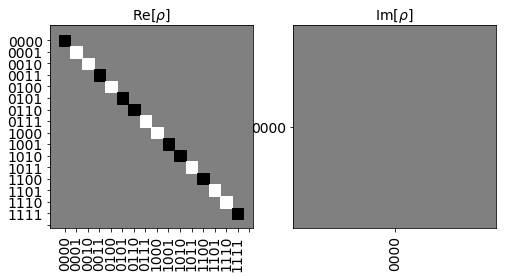

In [57]:
plot_state_hinton(H_k)

In [58]:
qc = QuantumCircuit(4)
qc.diagonal(list(np.diag(np.round(H_k, 9))), [0,1,2,3])
qc = transpile(qc, basis_gates=['cx','u3'], optimization_level=3)
qc.draw()

┌───┐┌───┐┌───┐┌─────────────┐┌───┐┌───┐┌───┐
q_0: ┤ X ├┤ X ├┤ X ├┤ U3(0,0,-pi) ├┤ X ├┤ X ├┤ X ├
     └─┬─┘└─┬─┘└─┬─┘└─────────────┘└─┬─┘└─┬─┘└─┬─┘
q_1: ──┼────┼────■───────────────────┼────■────┼──
       │    │                        │         │  
q_2: ──■────┼────────────────────────■─────────┼──
            │                                  │  
q_3: ───────■──────────────────────────────────■──

In [59]:
qc = QuantumCircuit(4)
qc.isometry(np.round(H_k, 9), [0,1,2,3], [])
qc = transpile(qc, basis_gates=['cx','u3'], optimization_level=3)
qc.draw()

┌─────────────────────┐
q_0: ┤ U3(0,1.6167,1.5249) ├
     └───┬─────────────┬───┘
q_1: ────┤ U3(0,0,-pi) ├────
         ├─────────────┴┐   
q_2: ────┤ U3(0,0,-3pi) ├───
         ├─────────────┬┘   
q_3: ────┤ U3(0,0,-pi) ├────
         └─────────────┘

# Compute eigenvalues and eigenvectors of Hamiltonian

In [73]:
# Compute eigenvalues and eigenvectors
# Should be four ground states because lattice is on a torus
# 1st excited state energy must be 4 above ground state again due to torus manifold
eigen_vals, eigen_vecs = np.linalg.eig(H_k)  # np.real is used to removed 1e-17j values

# Clean up eigenvalues
eigen_vals = np.round(np.real(eigen_vals), 4)
unqiue_eigvals, counts = np.unique(eigen_vals, return_counts=True)
print(unqiue_eigvals, counts)

# normalize eigenvectors
eigen_vecs = np.round(np.real(eigen_vecs), 4)
norms = np.linalg.norm(eigen_vecs, ord=2, axis=1)
for i, norm in enumerate(norms):
    eigen_vecs[i] = eigen_vecs[i] / norm
print('average norm:', np.mean(np.linalg.norm(eigen_vecs, ord=2, axis=1)))

[-1.  1.] [8 8]
average norm: 1.0


In [74]:
# 4 ground states and check orthogonality
ground_states = []
ground_energy = eigen_vals.min()
for i, val in enumerate(eigen_vals):
    if val == ground_energy:
        ground_states.append(eigen_vecs[i])

# Inner product should be 1 between ground state 0 and itself and 0 between ground state 0 and the other 3 ground states  
for j in range(len(ground_states)):
    print('inner prodict of 0 and ',j,'state')
    inner_product = np.matmul(np.conj(ground_states[0]), ground_states[j][np.newaxis].T)[0]
    print(inner_product)


inner prodict of 0 and  0 state
1.0
inner prodict of 0 and  1 state
0.0
inner prodict of 0 and  2 state
0.0
inner prodict of 0 and  3 state
0.0
inner prodict of 0 and  4 state
0.0
inner prodict of 0 and  5 state
0.0
inner prodict of 0 and  6 state
0.0
inner prodict of 0 and  7 state
0.0


In [75]:
error = np.kron(np.kron(np.kron(iden, z), iden), iden)

i = 2
np.matmul(np.conj(ground_states[i]), np.matmul(H_k, np.matmul(error, ground_states[i])))

1.0

# Ground states
From the ```ground_states``` list the eight ground states in Dirac notation are:
$$
\begin{align}
|\psi_0^{(1)} \rangle &= |0000\rangle \\
|\psi_0^{(2)} \rangle &= |1100\rangle \\
|\psi_0^{(3)} \rangle &= |1010\rangle \\
|\psi_0^{(4)} \rangle &= |0110\rangle \\
|\psi_0^{(5)} \rangle &= |1001\rangle \\
|\psi_0^{(6)} \rangle &= |0101\rangle \\
|\psi_0^{(7)} \rangle &= |0011\rangle \\
|\psi_0^{(8)} \rangle &= |1111\rangle
\end{align}
$$

These are the same states used to make up the [4,2,2] code!! The [4,2,2] codespace is:

$$
\begin{align}
|00\rangle_L &= |0000\rangle + |1111\rangle \\
|01\rangle_L &= |1100\rangle + |0011\rangle \\
|10\rangle_L &= |1010\rangle + |0101\rangle \\
|11\rangle_L &= |0110\rangle + |1001\rangle
\end{align}
$$

For [4,2,2] code can detection any single qubit error, but cannot correct errors. [Gottesman 2016](https://arxiv.org/abs/1610.03507). Coincidental? Seems unlikely.

# Error Susceptibility 
In the Toric Code $N_{spins} \gg $ the number of local errors. In the case of $N_{spins} = 4$, we may not have that topological protect which makes this such a useful quantum memory. Let's see if this case still satisfies the two conditions of QEC: error distinguishability and non-demolish measurement.